In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas_ta as ta
import itertools
from tqdm import tqdm
import random
import multiprocessing

In [2]:
def get_df():
    df = pd.read_parquet('data.parquet', engine='pyarrow')
    cols = ['time', 'close']
    df = df[cols]
    return df

In [3]:
def add_sma(df, SMA_short, SMA_long):
    
    df["SMA_short"] = ta.sma(df['close'], SMA_short)
    df["SMA_long"] = ta.sma(df['close'], SMA_long)
        
    df = df.dropna().reset_index(drop=True)
    
    return df

In [4]:
def add_signals(df):
    buy_condition = (df['SMA_short'] >= df['SMA_long']) & (df['SMA_short'].shift(1) < df['SMA_long'].shift(1))
    sell_condition = (df['SMA_short'] < df['SMA_long']) & (df['SMA_short'].shift(1) >= df['SMA_long'].shift(1))

    df['signals_buy'] = df.loc[buy_condition, 'close']
    df['signals_sell'] = df.loc[sell_condition, 'close']

    return df

In [5]:
def evaluate_signals(df):

    buys = df["signals_buy"].dropna()
    sells = df["signals_sell"].dropna()
    
    # TODO is overall_profit_multiplier calculated properly?
    return {
        "profit_multiplier": sells.mean() / buys.mean(),
        "buy_sell_trade_pair_count": (buys.count() + sells.count()) / 2,
        "overall_profit_multiplier": (sells.mean() / buys.mean() - 1) * (buys.count() + sells.count()) / 2
    }

In [6]:
SMA_short_values = list(range(2,1000))
SMA_long_values = list(range(2,1000))
# Calculate all of the combinations
sma_combinations = list(itertools.product(SMA_short_values, SMA_long_values))

# skip same value pairs
sma_combinations = [(short, long) for (short, long) in sma_combinations if short != long]

sma_combinations = random.choices(sma_combinations, k = min(len(sma_combinations), 1000))

In [7]:
df_raw = get_df()

def calculate_result(sma_pair):
    sma_short, sma_long = sma_pair
    
    df = add_signals(add_sma(df_raw, sma_short, sma_long))
    
    result = {
        "SMA_short": sma_short,
        "SMA_long": sma_long
    }
    
    result.update(evaluate_signals(df))
    
    return result


with multiprocessing.Pool() as pool:
    results = []
    for result in tqdm(pool.imap_unordered(calculate_result, sma_combinations), total=len(sma_combinations)):
        results.append(result)
            
results = pd.DataFrame(results)

100%|██████████| 1000/1000 [02:24<00:00,  6.90it/s]


In [8]:
pd.options.display.float_format = '{:.20f}'.format
results.nlargest(10, 'profit_multiplier')

,SMA_short,SMA_long,profit_multiplier,buy_sell_trade_pair_count,overall_profit_multiplier
632,703,989,1.00101899498834789881,1909.50000000000000000000,1.94577093025031278017
854,692,996,1.00097702560841628205,1886.50000000000000000000,1.84315881027731620634
927,316,972,1.00097085873237978682,1883.50000000000000000000,1.82861242243732835533
639,783,964,1.00086025980268233937,2298.50000000000000000000,1.97730715646535704089
551,751,999,1.00085295793914763607,1984.50000000000000000000,1.69269503023848377765
723,465,316,1.00085154519155250519,4141.00000000000000000000,3.52624863821892375881
291,497,296,1.00082584720739187212,3737.00000000000000000000,3.08619101402342632667
537,311,938,1.00082263014390604461,1930.50000000000000000000,1.58808749281061922787
380,462,329,1.00082087968979815962,4274.00000000000000000000,3.50843979419733420499
995,452,319,1.00080789966052963180,4381.00000000000000000000,3.53940841278031692596


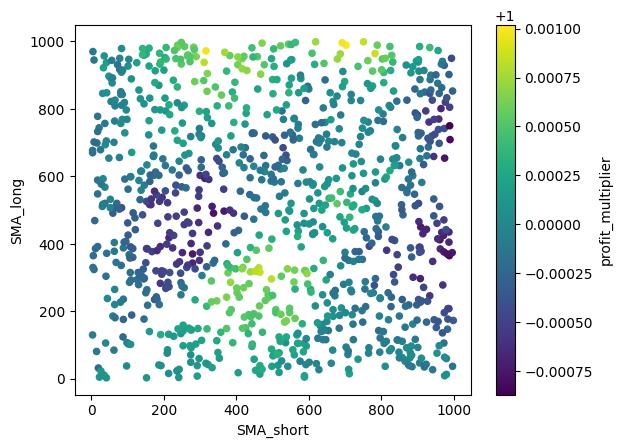

In [9]:
ax = results.plot(x="SMA_short", y="SMA_long", kind="scatter", c="profit_multiplier", colormap="viridis")


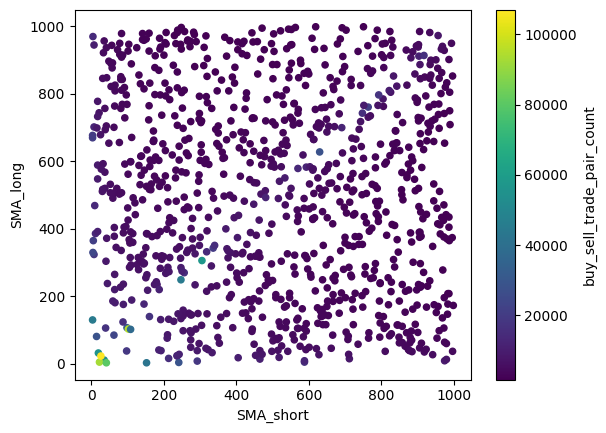

In [10]:
ax = results.plot(x="SMA_short", y="SMA_long", kind="scatter", c="buy_sell_trade_pair_count", colormap="viridis")

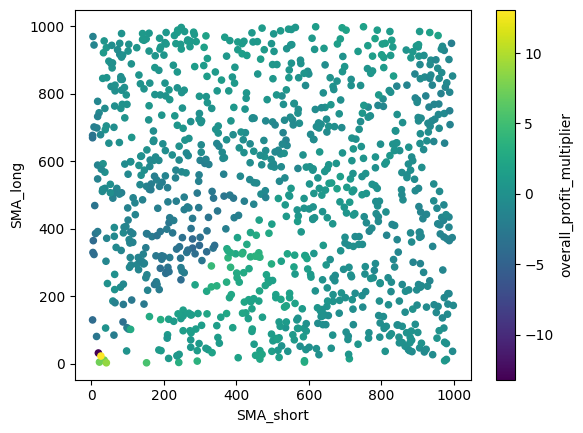

In [11]:
ax = results.plot(x="SMA_short", y="SMA_long", kind="scatter", c="overall_profit_multiplier", colormap="viridis")